## Calculate different centrality measurement of urban mobility via CDR in Sierra Leone.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import timeit

import matplotlib.pyplot as plt
%matplotlib notebook

import networkx as nx

In [2]:
# file paths
home = "/Users/yanchao/000_2020MIT_FALL/SL/data/towerOD/"
path1 = 'feb_graph.csv'
path2 = 'april_graph.csv'
path_loc = 'loc.csv'
path_shape = "/Users/yanchao/000_2020MIT_FALL/SL/data/current_admin/sections/section.shp"

# 1. Read Files

In [138]:
# graph format of cdr flow
# see another file for transforming raw data into graph format

p = pd.read_csv(home + path1)
p

,Unnamed: 0,orinode,desnode,count,oriloc,desloc
0,0,1,0,153.300000,"(6.96844, -11.57535)","(7.02457, -11.38846)"
1,1,2,0,115.950000,"(7.15579, -11.37431)","(7.02457, -11.38846)"
2,2,3,0,109.700000,"(7.315155, -11.306095)","(7.02457, -11.38846)"
3,3,36,0,31.583333,"(7.863969, -11.196261)","(7.02457, -11.38846)"
4,4,5,0,120.650000,"(7.96143, -11.7417)","(7.02457, -11.38846)"
...,...,...,...,...,...,...
12846,12846,318,317,428.500000,"(9.916538, -11.449949)","(9.86506, -11.42903)"
12847,12847,256,318,63.300000,"(9.589409, -11.546852)","(9.916538, -11.449949)"
12848,12848,302,318,60.250000,"(9.709185, -11.548924)","(9.916538, -11.449949)"
12849,12849,316,318,76.550000,"(9.854077, -11.322257)","(9.916538, -11.449949)"


/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<IPython.core.display.Javascript object>


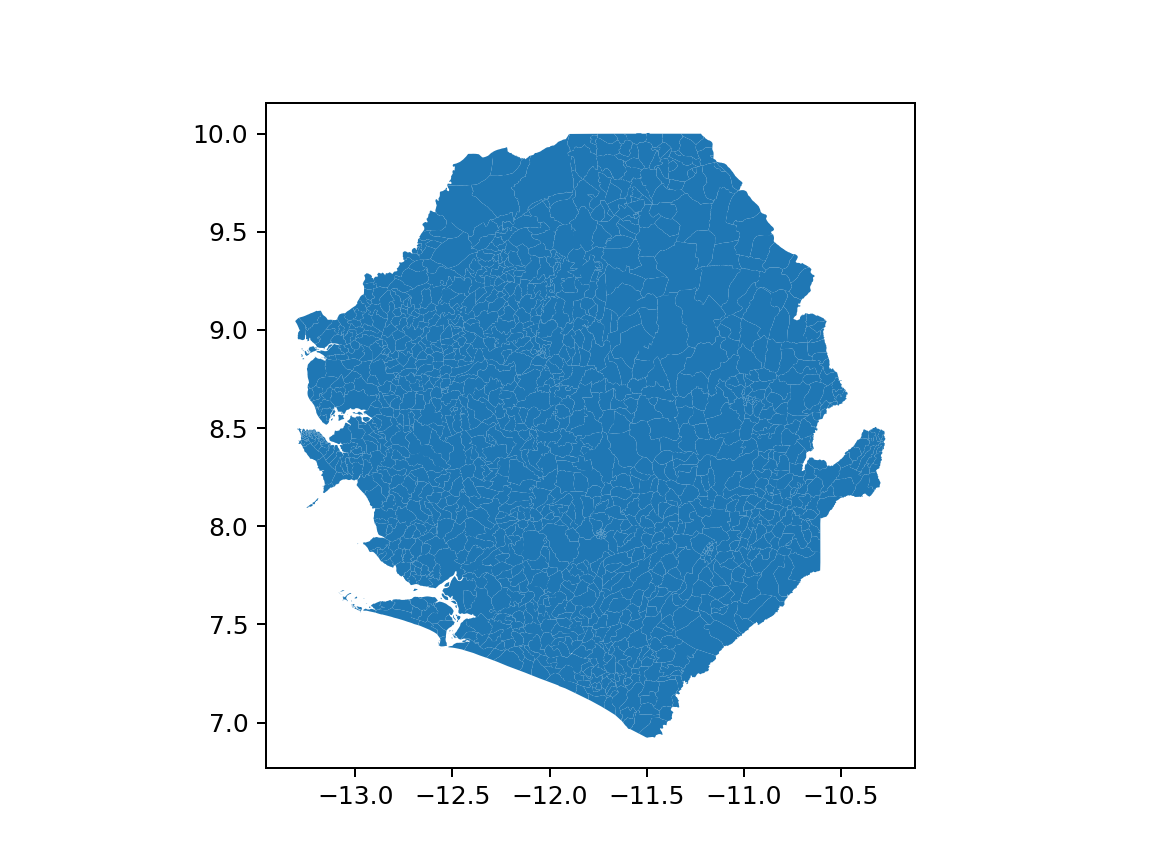

In [19]:
shape = gpd.read_file( path_shape)
shape = shape.to_crs({'init': 'epsg:4326'})
shape.plot()

In [9]:
loc = pd.read_csv(home + path_loc)
loc

,Unnamed: 0,node,pos,lat,lon
0,0,0.0,"(7.02457, -11.38846)",7.024570,-11.388460
1,1,1.0,"(6.96844, -11.57535)",6.968440,-11.575350
2,2,2.0,"(7.15579, -11.37431)",7.155790,-11.374310
3,3,3.0,"(7.315155, -11.306095)",7.315155,-11.306095
4,4,5.0,"(7.96143, -11.7417)",7.961430,-11.741700
...,...,...,...,...,...
323,323,302.0,"(9.709185, -11.548924)",9.709185,-11.548924
324,324,315.0,"(9.661688, -11.718794)",9.661688,-11.718794
325,325,316.0,"(9.854077, -11.322257)",9.854077,-11.322257
326,326,317.0,"(9.86506, -11.42903)",9.865060,-11.429030


# 2. Build Graphs

In [21]:
# add real position to each node (tower)
pos = {}

for label, row in loc.iterrows():
    key = str(int(row['node']))
    value = np.array((round(row['lon'],7), round(row['lat'],7))) # round to 7 digits

    pos[key] = value

In [24]:
# build the graph
elist = []
for label, row in p.iterrows():
    temp = [str(row['orinode']),str(row['desnode']),row['count']]
    elist.append(temp)

G = nx.DiGraph()

# add edges
G.add_weighted_edges_from(elist)

# add node with position
for n, p in pos.items():
    if n in G.nodes:
        G.nodes[n]['pos'] = p


In [25]:
print(len(elist))

12851


<IPython.core.display.Javascript object>


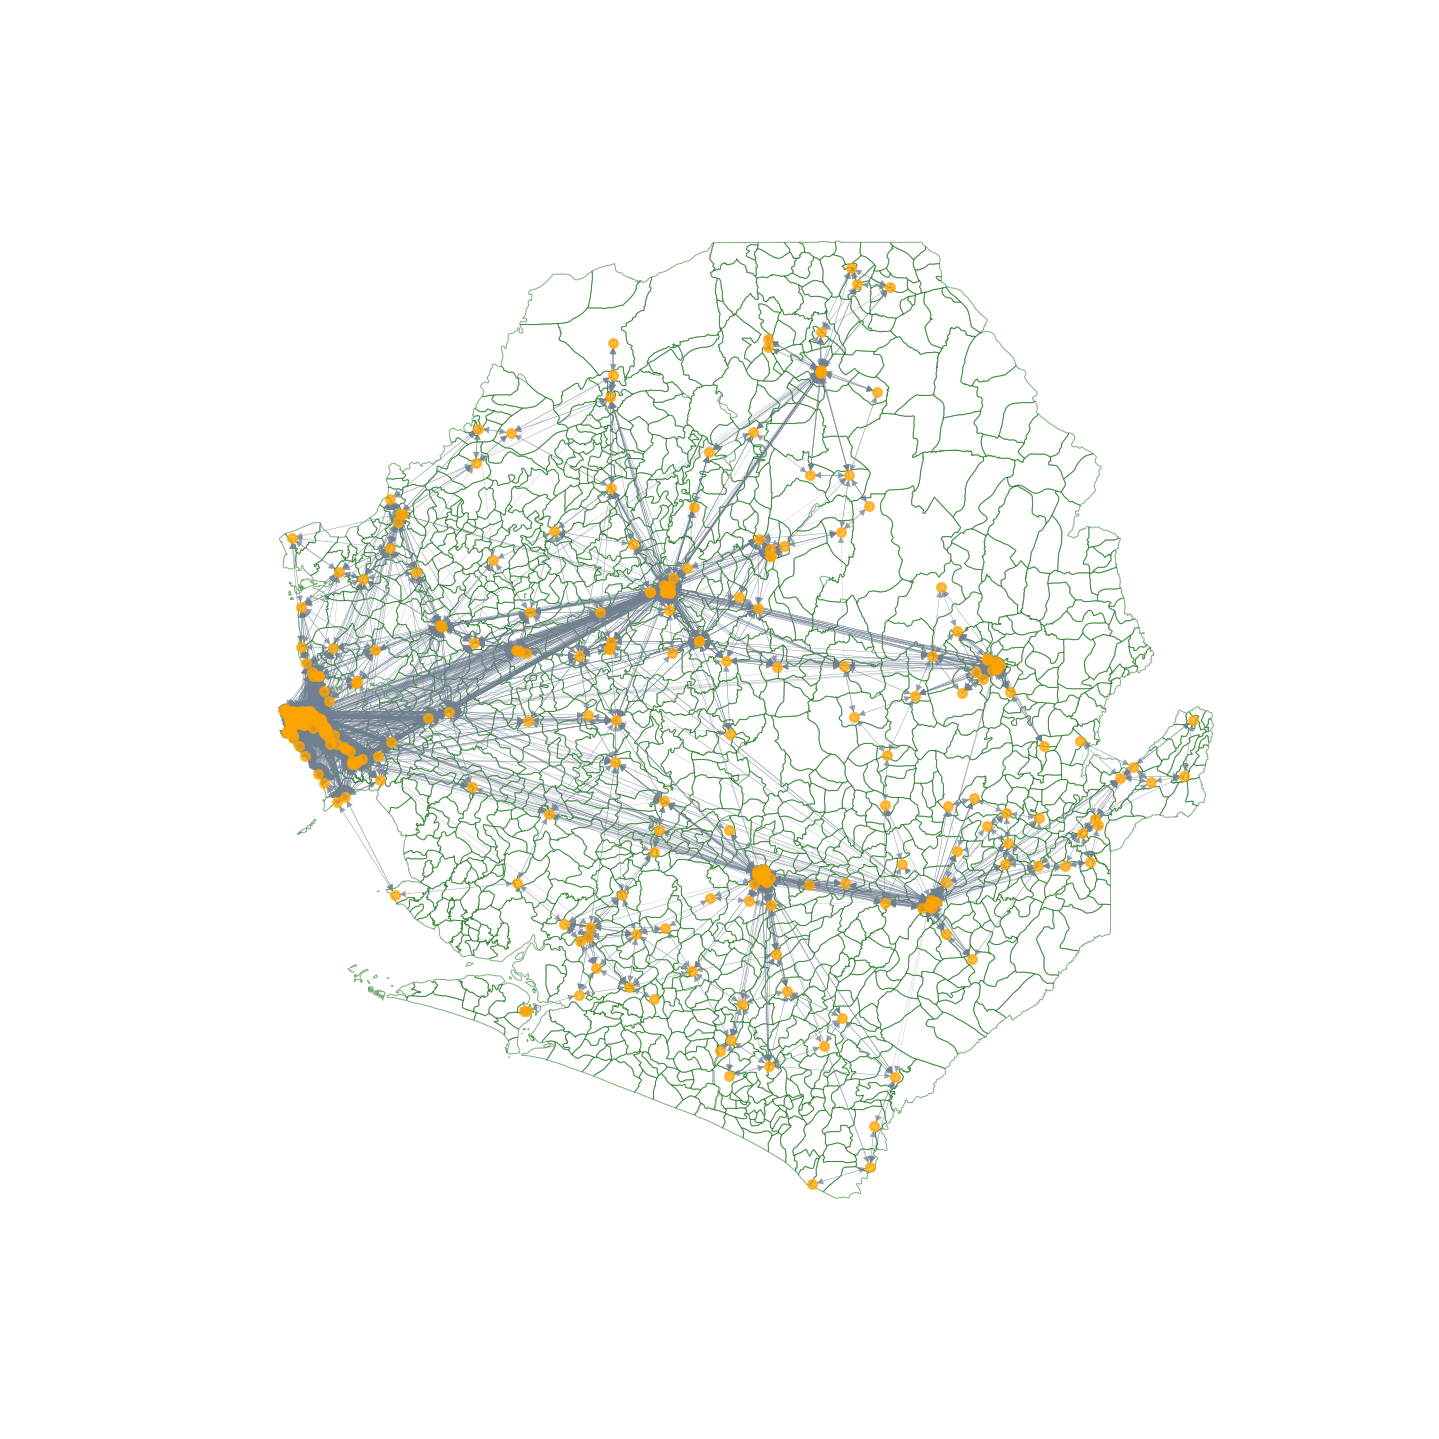

In [26]:
fig, ax = plt.subplots(figsize = (8,8))

#weights
weights = nx.get_edge_attributes(G,'weight').values()
shape.plot(ax = ax, facecolor = 'none', edgecolor = 'darkgreen', alpha = 0.1, linewidth = 0.4)
nx.draw(G, pos, width=0.03 *np.log(list(weights)),node_color='orange',node_size = 12, alpha = 0.7, with_labels = False, edge_color = 'slategrey', arrowsize=6)
plt.show()


# 3. Centrality Measurements

In [28]:
## the network has only three strongly connected components, the largest one has almost all nodes (258/260)

# number of strongly connected components
cc = [len(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True)]
print(len(cc))

# number of nodes in the largest component
largest_cc = max(nx.strongly_connected_components(G), key=len)
print(len(largest_cc))

1
319


In [29]:
## edge density
m = len(G.edges())
n = len(G.nodes())
c_nodes = n*(n-1)
p = 2*m/c_nodes
p

0.2533664557086808

In [30]:
## centrality

#in_degree_dict
dictin = nx.in_degree_centrality(G)
node = list(dictin.keys())
cent = list(dictin.values())

# out_degree_dict
dictout = nx.out_degree_centrality(G)

cento = list(dictout.values())

# ev left: in-edge
dictleft = nx.eigenvector_centrality(G)
cenl = list(dictleft.values())

# ev right: out-edge
dictright = nx.eigenvector_centrality(G.reverse())
cenr = list(dictright.values())


## use undirect to calculate these two
Gcu = G.to_directed()
# closeness 
close = nx.closeness_centrality(Gcu)
clo = list(close.values())

# betweeness 
btwvalue = nx.betweenness_centrality(Gcu)
btw = list(btwvalue.values())

df = pd.DataFrame({'node':node, 'centin':cent, 'centout': cento,'centleft':cenl, 'centright':cenr,'close':clo ,'btw': btw})
df = round(df,3)
df

,node,centin,centout,centleft,centright,close,btw
0,1,0.003,0.003,0.000,0.0,0.252,0.000
1,0,0.016,0.016,0.000,0.0,0.337,0.009
2,2,0.006,0.006,0.000,0.0,0.254,0.000
3,3,0.025,0.022,0.000,0.0,0.339,0.003
4,36,0.082,0.091,0.002,0.0,0.421,0.015
...,...,...,...,...,...,...,...
314,318,0.013,0.013,0.000,0.0,0.292,0.000
315,278,0.022,0.016,0.000,0.0,0.337,0.003
316,307,0.006,0.009,0.000,0.0,0.256,0.000
317,303,0.009,0.009,0.000,0.0,0.261,0.000


# 4. Merge Multiple Layers

In [74]:
locs = gpd.read_file("/Users/yanchao/000_2020MIT_FALL/SL/data/voronoi/africell_new/africell_new.shp")
locs = locs[['Latitude','longitude','geometry']]
locs = locs.drop_duplicates().reset_index(drop = True)

In [58]:
def generate_loc(dataframe, lat_name, lon_name, loc_name):
    """
    INPUT:
    dataframe we use to generate a location. e.g., tower_trips
    lat_name, column name for latitude
    lon_name, column name for longitude
    
    OUTPUT:
    dataframe with a new added column called 'loc', is a tuple containing (lat, lon).
    """
    
    location = []
    dataframe[lat_name] = round(dataframe[lat_name],8) # to avoid some comupter store issue. For example, -13.218795 may be stored as -13.218795000000002
    dataframe[lon_name] = round(dataframe[lon_name],8)
    for label, row in dataframe.iterrows():
        t = (row[lat_name],row[lon_name])
        location.append(t) 
    dataframe[loc_name] = location
    return dataframe

In [53]:
# add real ocations to graph nodes
loc1 = []
for label, row in loc.iterrows():
    loc1.append(eval(row['pos']))
loc['pos'] = loc1
loc

,Unnamed: 0,node,pos,lat,lon
0,0,0.0,"(7.02457, -11.38846)",7.024570,-11.388460
1,1,1.0,"(6.96844, -11.57535)",6.968440,-11.575350
2,2,2.0,"(7.15579, -11.37431)",7.155790,-11.374310
3,3,3.0,"(7.315155, -11.306095)",7.315155,-11.306095
4,4,5.0,"(7.96143, -11.7417)",7.961430,-11.741700
...,...,...,...,...,...
323,323,302.0,"(9.709185, -11.548924)",9.709185,-11.548924
324,324,315.0,"(9.661688, -11.718794)",9.661688,-11.718794
325,325,316.0,"(9.854077, -11.322257)",9.854077,-11.322257
326,326,317.0,"(9.86506, -11.42903)",9.865060,-11.429030


In [78]:
locs = generate_loc(locs, 'Latitude', 'longitude', 'loc')
locs = locs.merge(loc[['node','pos']], left_on = 'loc',right_on = 'pos', how = 'inner')
locs

,Latitude,longitude,geometry,loc,node,pos
0,6.968440,-11.575350,POINT (-11.57535 6.96844),"(6.96844, -11.57535)",1.0,"(6.96844, -11.57535)"
1,7.024570,-11.388460,POINT (-11.38846 7.02457),"(7.02457, -11.38846)",0.0,"(7.02457, -11.38846)"
2,7.155790,-11.374310,POINT (-11.37431 7.15579),"(7.15579, -11.37431)",2.0,"(7.15579, -11.37431)"
3,7.315155,-11.306095,POINT (-11.30609 7.31515),"(7.315155, -11.306095)",3.0,"(7.315155, -11.306095)"
4,7.318590,-11.848260,POINT (-11.84826 7.31859),"(7.31859, -11.84826)",10.0,"(7.31859, -11.84826)"
...,...,...,...,...,...,...
323,8.455510,-13.178600,POINT (-13.17860 8.45551),"(8.45551, -13.1786)",235.0,"(8.45551, -13.1786)"
324,8.489115,-13.233005,POINT (-13.23300 8.48911),"(8.489115, -13.233005)",226.0,"(8.489115, -13.233005)"
325,8.456810,-13.273200,POINT (-13.27320 8.45681),"(8.45681, -13.2732)",321.0,"(8.45681, -13.2732)"
326,8.479817,-13.252206,POINT (-13.25221 8.47982),"(8.479817, -13.252206)",225.0,"(8.479817, -13.252206)"


In [92]:
locs['node2'] = (locs['node']).astype(str).apply(lambda x: x[:-2]) # change int to str
locs

,Latitude,longitude,geometry,loc,node,pos,node2
0,6.968440,-11.575350,POINT (-11.57535 6.96844),"(6.96844, -11.57535)",1.0,"(6.96844, -11.57535)",1
1,7.024570,-11.388460,POINT (-11.38846 7.02457),"(7.02457, -11.38846)",0.0,"(7.02457, -11.38846)",0
2,7.155790,-11.374310,POINT (-11.37431 7.15579),"(7.15579, -11.37431)",2.0,"(7.15579, -11.37431)",2
3,7.315155,-11.306095,POINT (-11.30609 7.31515),"(7.315155, -11.306095)",3.0,"(7.315155, -11.306095)",3
4,7.318590,-11.848260,POINT (-11.84826 7.31859),"(7.31859, -11.84826)",10.0,"(7.31859, -11.84826)",10
...,...,...,...,...,...,...,...
323,8.455510,-13.178600,POINT (-13.17860 8.45551),"(8.45551, -13.1786)",235.0,"(8.45551, -13.1786)",235
324,8.489115,-13.233005,POINT (-13.23300 8.48911),"(8.489115, -13.233005)",226.0,"(8.489115, -13.233005)",226
325,8.456810,-13.273200,POINT (-13.27320 8.45681),"(8.45681, -13.2732)",321.0,"(8.45681, -13.2732)",321
326,8.479817,-13.252206,POINT (-13.25221 8.47982),"(8.479817, -13.252206)",225.0,"(8.479817, -13.252206)",225


In [95]:
# merge together with the geospastial map

df0 = locs.merge(df, left_on = 'node2', right_on = 'node', how = 'inner')
df0

,Latitude,longitude,geometry,loc,node_x,pos,node2,node_y,centin,centout,centleft,centright,close,btw
0,6.968440,-11.575350,POINT (-11.57535 6.96844),"(6.96844, -11.57535)",1.0,"(6.96844, -11.57535)",1,1,0.003,0.003,0.000,0.000,0.252,0.000
1,7.024570,-11.388460,POINT (-11.38846 7.02457),"(7.02457, -11.38846)",0.0,"(7.02457, -11.38846)",0,0,0.016,0.016,0.000,0.000,0.337,0.009
2,7.155790,-11.374310,POINT (-11.37431 7.15579),"(7.15579, -11.37431)",2.0,"(7.15579, -11.37431)",2,2,0.006,0.006,0.000,0.000,0.254,0.000
3,7.315155,-11.306095,POINT (-11.30609 7.31515),"(7.315155, -11.306095)",3.0,"(7.315155, -11.306095)",3,3,0.025,0.022,0.000,0.000,0.339,0.003
4,7.318590,-11.848260,POINT (-11.84826 7.31859),"(7.31859, -11.84826)",10.0,"(7.31859, -11.84826)",10,10,0.009,0.006,0.000,0.000,0.331,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,8.489060,-13.250400,POINT (-13.25040 8.48906),"(8.48906, -13.2504)",263.0,"(8.48906, -13.2504)",263,263,0.003,0.009,0.001,0.004,0.295,0.000
315,8.455510,-13.178600,POINT (-13.17860 8.45551),"(8.45551, -13.1786)",235.0,"(8.45551, -13.1786)",235,235,0.063,0.072,0.023,0.026,0.374,0.000
316,8.489115,-13.233005,POINT (-13.23300 8.48911),"(8.489115, -13.233005)",226.0,"(8.489115, -13.233005)",226,226,0.154,0.116,0.056,0.043,0.387,0.000
317,8.479817,-13.252206,POINT (-13.25221 8.47982),"(8.479817, -13.252206)",225.0,"(8.479817, -13.252206)",225,225,0.245,0.239,0.082,0.080,0.408,0.000


# 5. Visualization

<IPython.core.display.Javascript object>


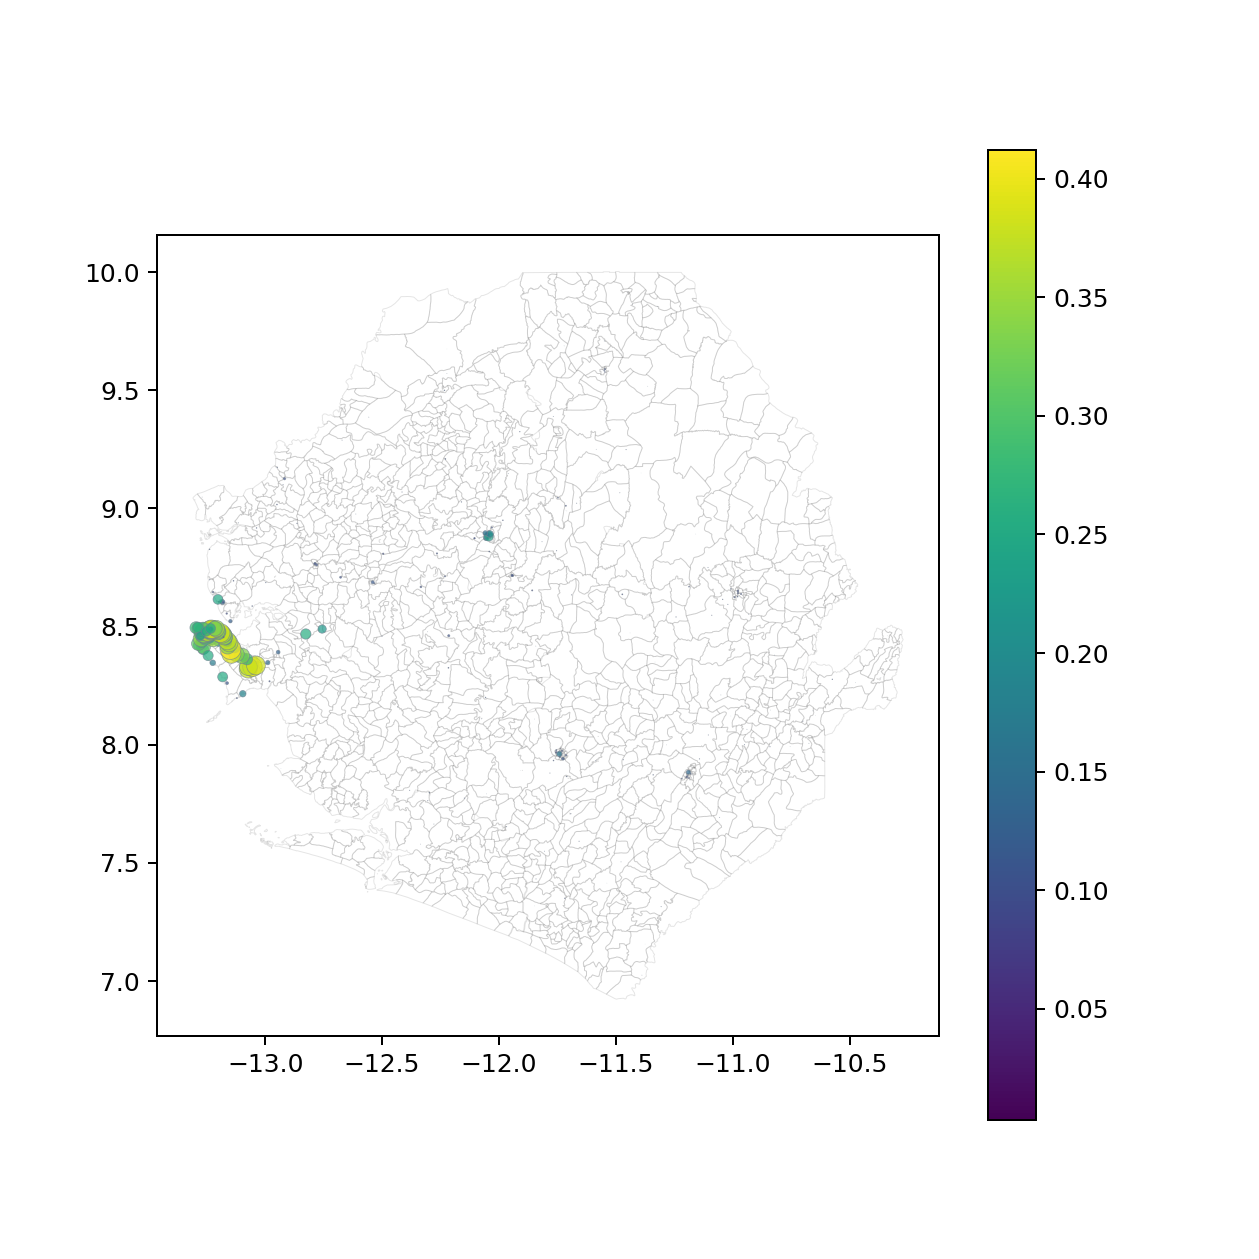

In [99]:
# in-degree centrality

coef = 1000
variable = 'centin'
fig,ax = plt.subplots(figsize = (7,7))
shape.plot(ax = ax, facecolor = 'none', edgecolor = 'black', alpha = 0.1, linewidth = 0.4)
df0.plot(ax = ax, column = variable, c = 'viridis',edgecolor = 'slategrey', markersize = coef * (df0[variable])**3, legend = True, alpha = 0.7, linewidth = 0.3)


<IPython.core.display.Javascript object>


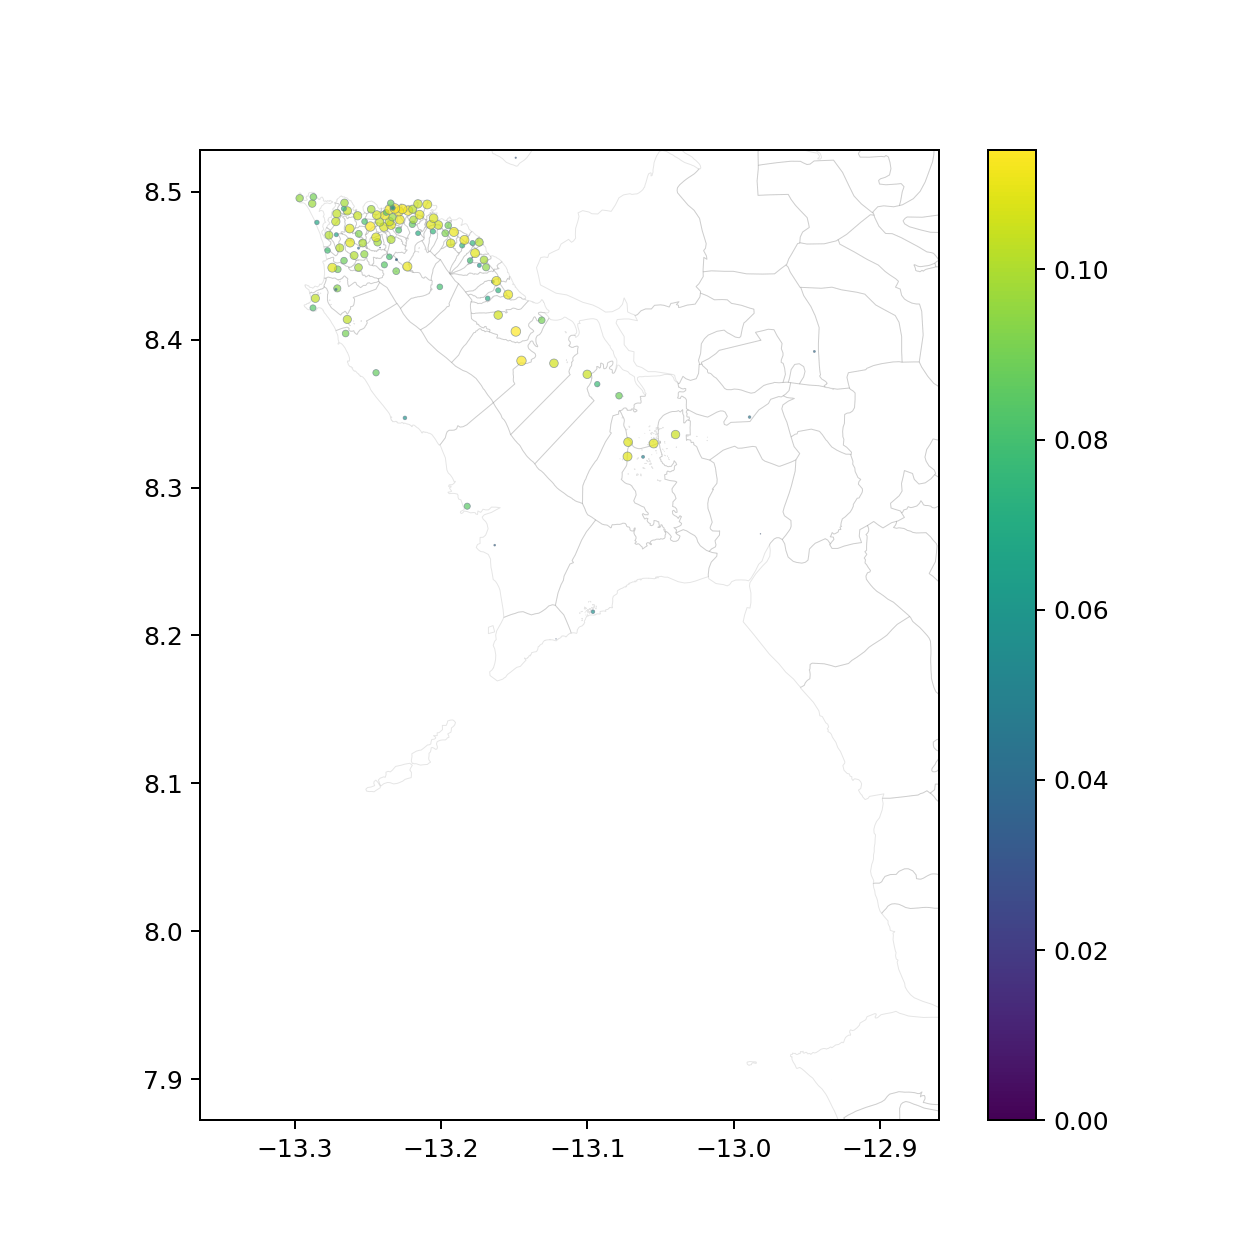

In [111]:
# left-eigenvalue centrality

coef = 10000
variable = 'centleft'
fig,ax = plt.subplots(figsize = (7,7))
shape.plot(ax = ax, facecolor = 'none', edgecolor = 'black', alpha = 0.1, linewidth = 0.4)
df0.plot(ax = ax, column = variable, c = 'viridis',edgecolor = 'slategrey', markersize = coef * (df0[variable])**3, legend = True, alpha = 0.7, linewidth = 0.3)


<IPython.core.display.Javascript object>


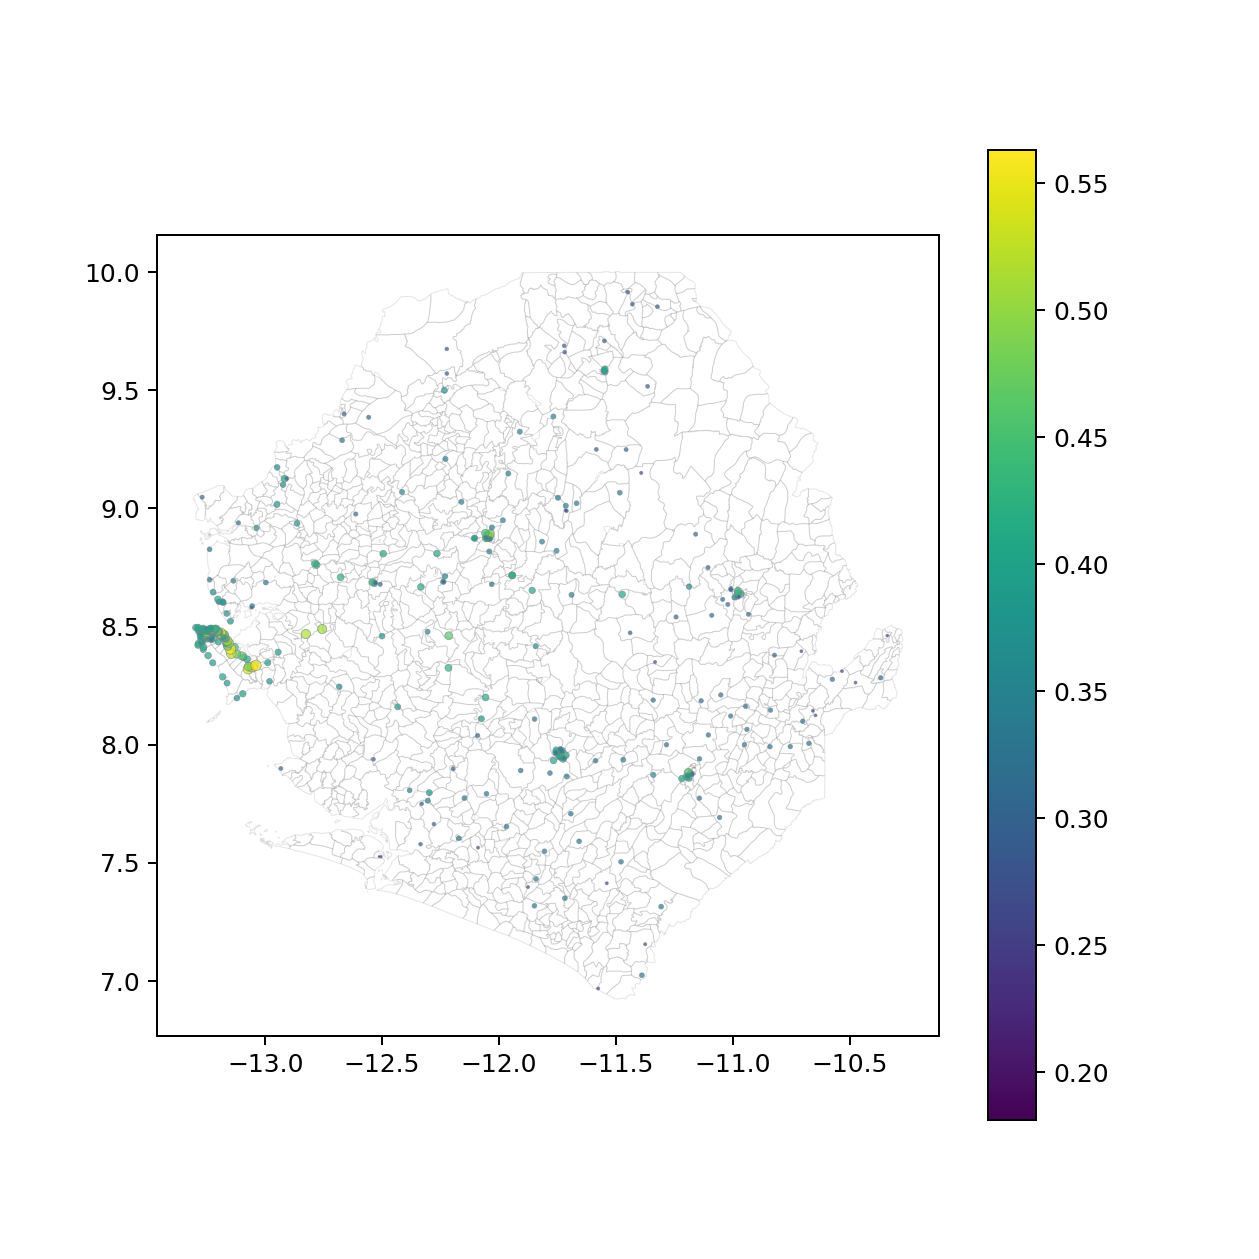

In [104]:
# closeness centrality

coef = 100
variable = 'close'
fig,ax = plt.subplots(figsize = (7,7))
shape.plot(ax = ax, facecolor = 'none', edgecolor = 'black', alpha = 0.1, linewidth = 0.4)
df0.plot(ax = ax, column = variable, c = 'viridis',edgecolor = 'slategrey', markersize = coef * (df0[variable])**3, legend = True, alpha = 0.7, linewidth = 0.3)


<IPython.core.display.Javascript object>


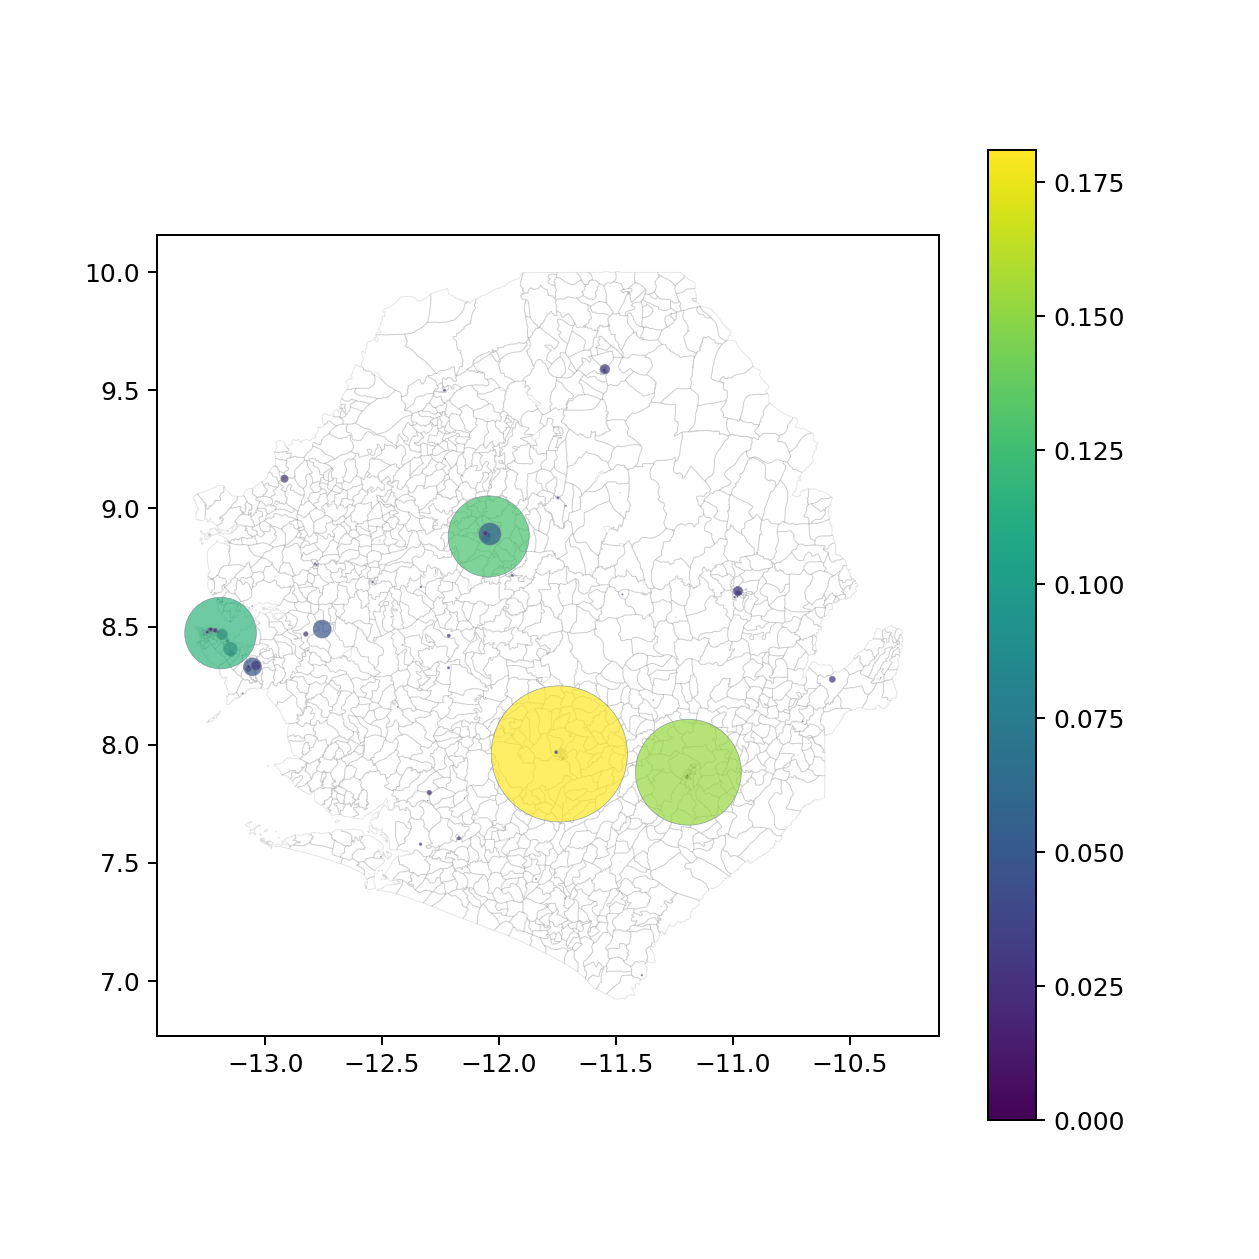

In [108]:
# betweenness centrality

coef = 500000
variable = 'btw'
fig,ax = plt.subplots(figsize = (7,7))
shape.plot(ax = ax, facecolor = 'none', edgecolor = 'black', alpha = 0.1, linewidth = 0.4)
df0.plot(ax = ax, column = variable, c = 'viridis',edgecolor = 'slategrey', markersize = coef * (df0[variable])**3, legend = True, alpha = 0.7, linewidth = 0.3)


In [161]:
# store the data
df4.to_csv(home + 'centrality_feb_uniqueLoc.csv')